# Example: MutiSolSegment Cell EL segmentation
In this example we segment solar cell EL images

In [1]:
import os
from pathlib import Path

project_root = Path.cwd().parents[1]
os.chdir(project_root)   # now cwd is .../pvcracks

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from pvcracks.utils import train_functions
from pvcracks.utils.segmentation import segment

import requests

from PIL import Image


In [2]:
root = Path.cwd()
print(root)

/home/nrjost/githome/pvcracks


#### Download MutiSolSegment weights (https://doi.org/10.21948/2997859)

In [3]:
weight_path = "multisolsegment.pt"
response = requests.get("https://datahub.duramat.org/dataset/24d7ed98-956e-4ebc-bf21-6584ecec2ff1/resource/e6d5dee2-0aef-439e-978c-d8c572e7039e/download/model.pt")

with open(weight_path, "wb") as f:
    f.write(response.content)

#### Load MultisolSegment

In [4]:
category_mapping = {0: "dark", 1: "busbar", 2: "crack", 3: "non-cell"}

device, model = train_functions.load_device_and_model(
    category_mapping, existing_weight_path=weight_path
)

#### Example EL Images

In [5]:
Cell9Master = pd.read_csv('docs/data/ELdata_module_209.csv', index_col=0)

#### Load one EL Image convert and resize (prepare for segemntation)


Text(0.5, 1.0, 'Cell EL Image')

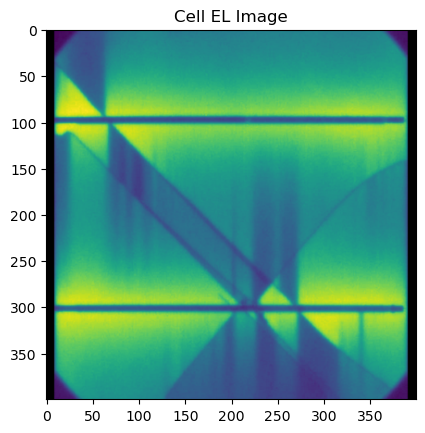

In [6]:
from torchvision import transforms
import torchvision.transforms.functional as F

ELPath = Cell9Master.ELPath[25] #Specific image with cracks
image_raw = Image.open(f"{os.getcwd()}{ELPath}") #Load image with PIL
image_rgb = image_raw.convert("RGB") #Convert to GPB
image_rot = image_rgb.rotate(90) #Rotate to have busbars horizontal to be detected with segmentation model

image = F.resize(image_rot, (400, 400), interpolation=transforms.InterpolationMode.BILINEAR)
#image has to be sized 400x400 to work with the segmentation model
# arr = np.asarray(image) #convert image into np.array, not necessary if PIL.Image
plt.imshow(image)
plt.title("Cell EL Image")

#### Segment the EL image

In [7]:
dark, bb, crack, nocell = segment(image, device, model)

#### Plot all segmented masks side by side

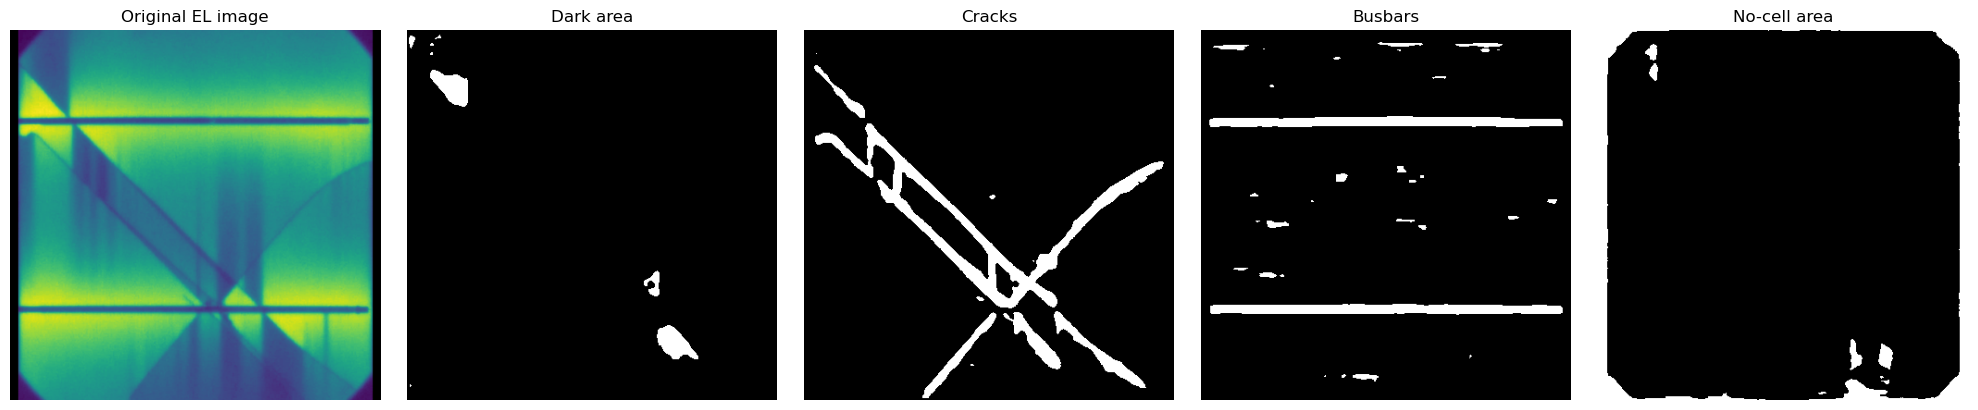

In [8]:
arrays = [image, dark, crack, bb, nocell]
titles = [
    "Original EL image",
    "Dark area",
    "Cracks",
    "Busbars",
    "No-cell area"
]

# create a row of 5 plots
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for ax, arrimg, title in zip(axes, arrays, titles):
    im = ax.imshow(arrimg, cmap="gray")   # or choose another cmap
    ax.set_title(title, fontsize=12)
    ax.axis("off")

plt.tight_layout()
plt.show()

#### Segment all images
- EL images are loaded
- Images are converted to RGB, rotated and resized
- Images are passed through the segmentation model
- Images and masks are plotted

This is the same approach that would be used for making the training dataset of the VAE model

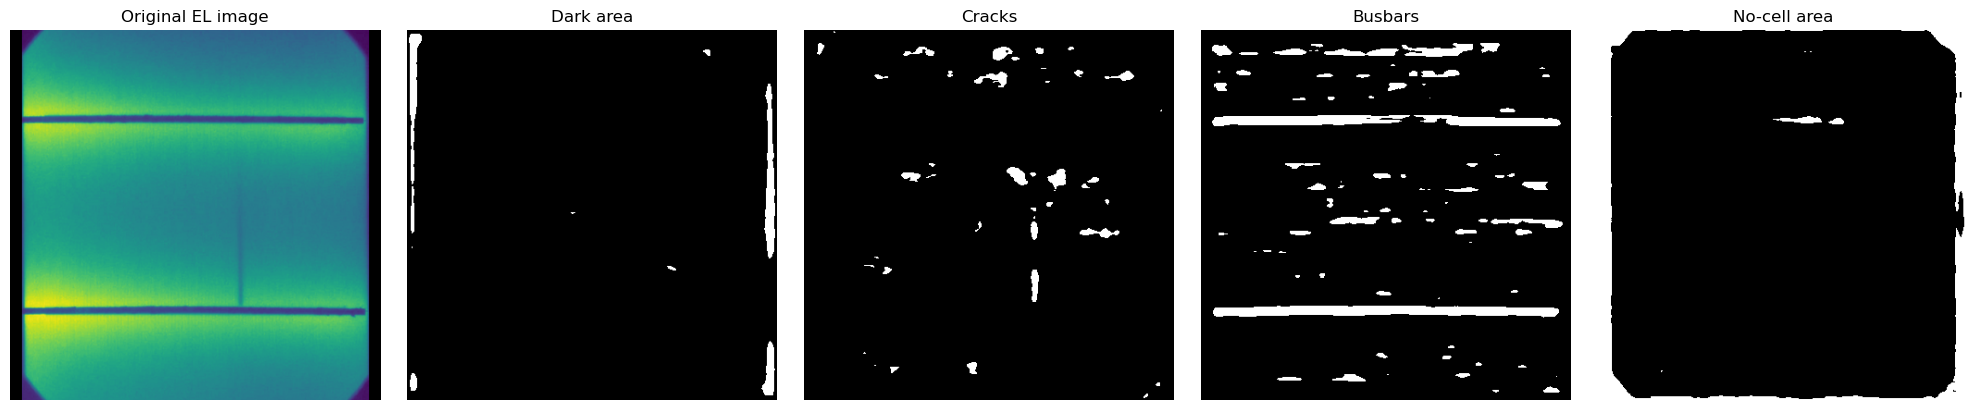

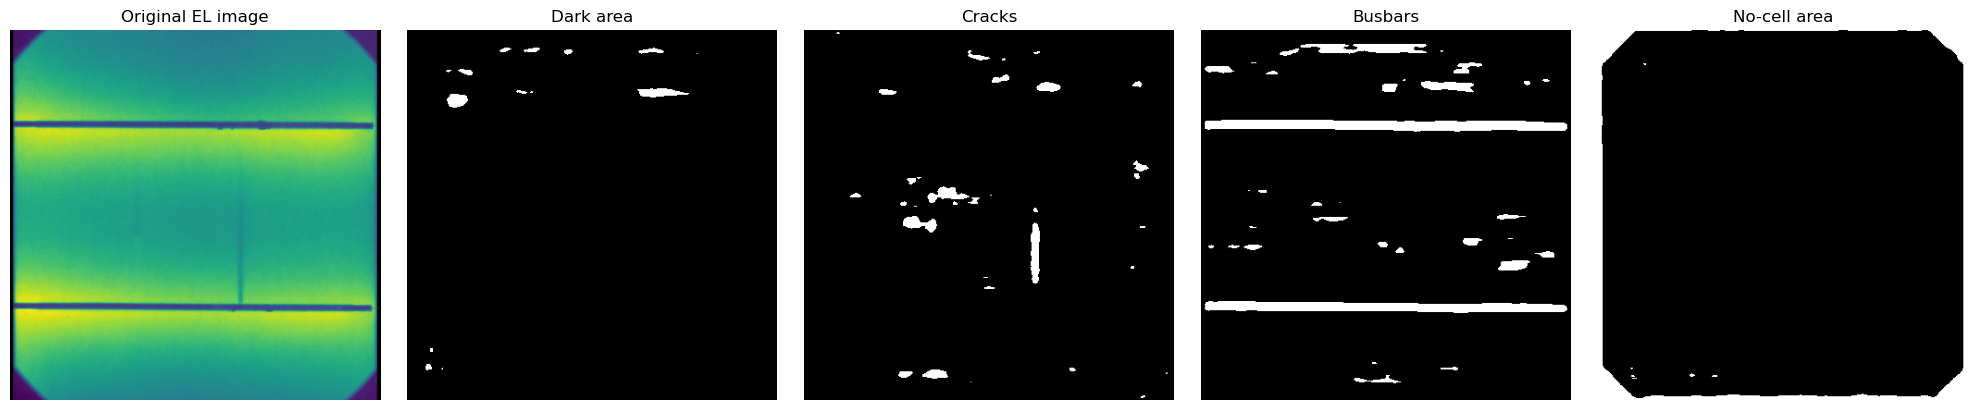

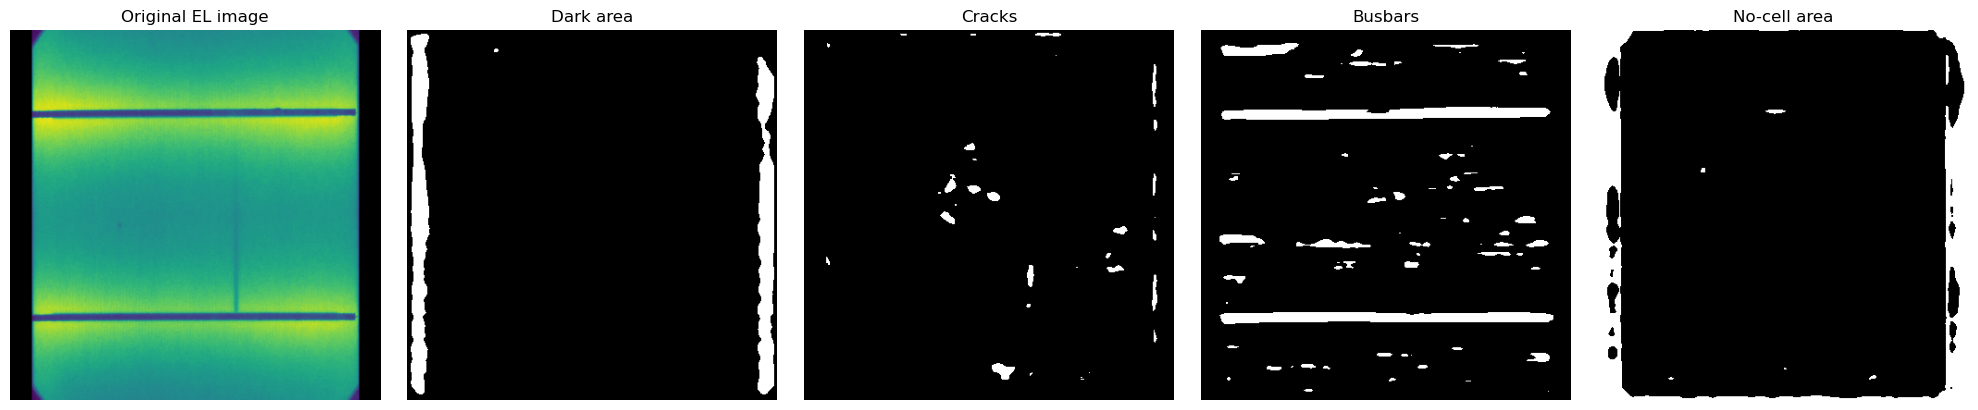

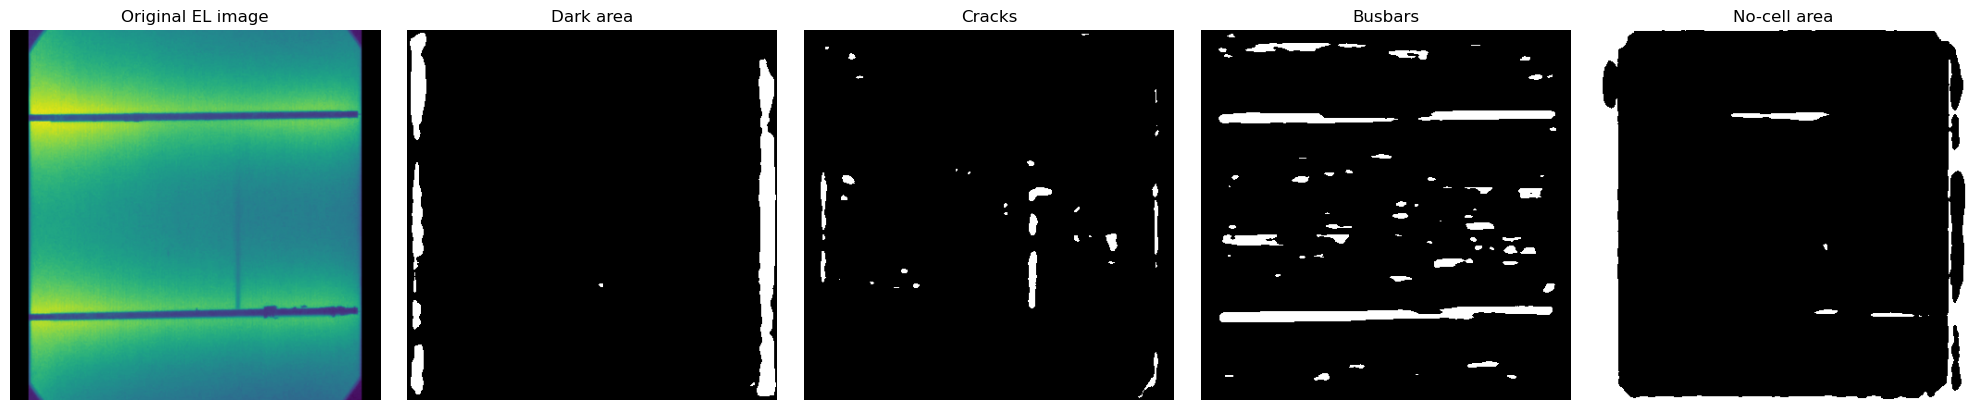

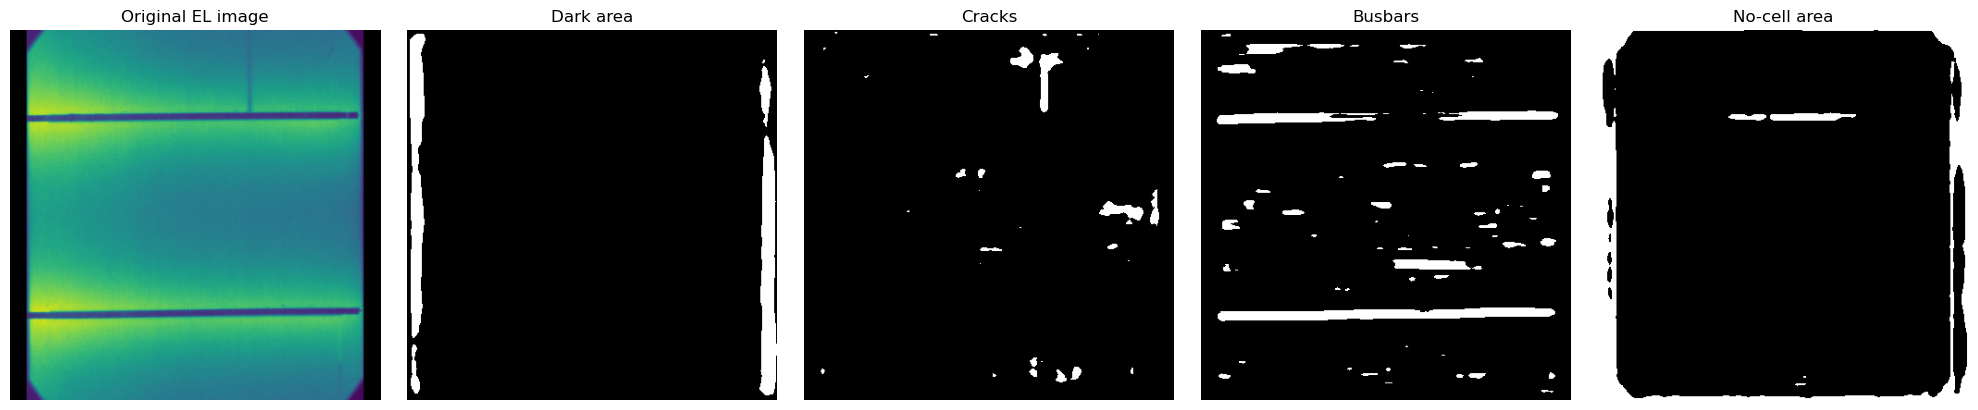

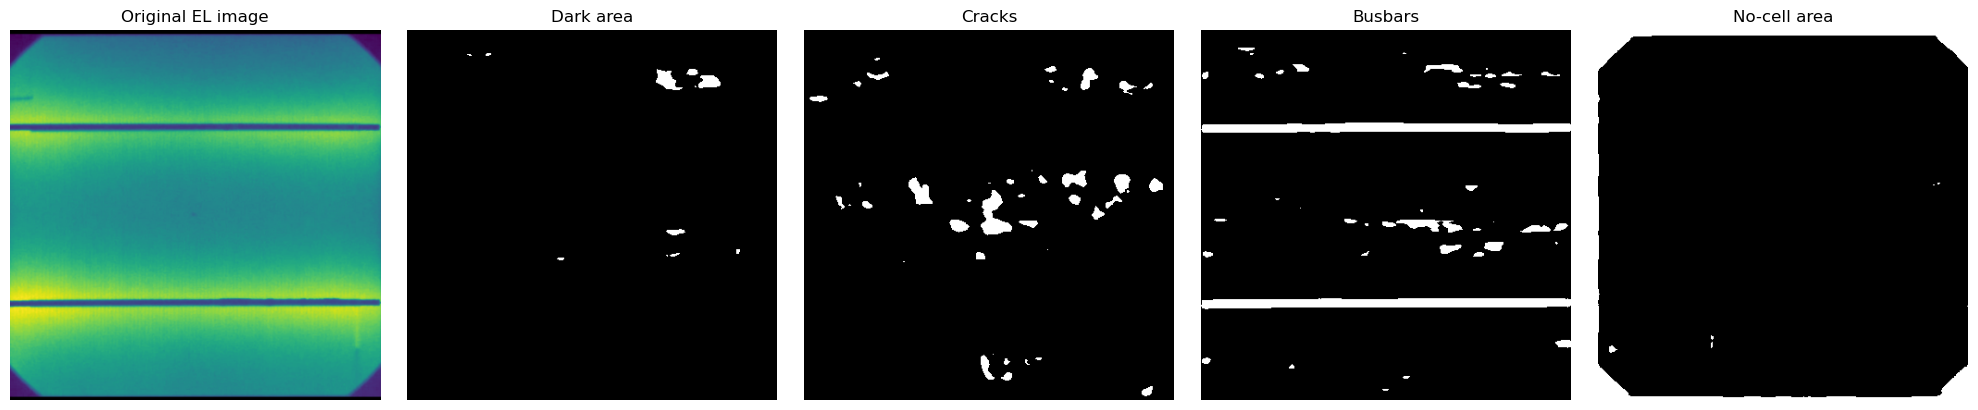

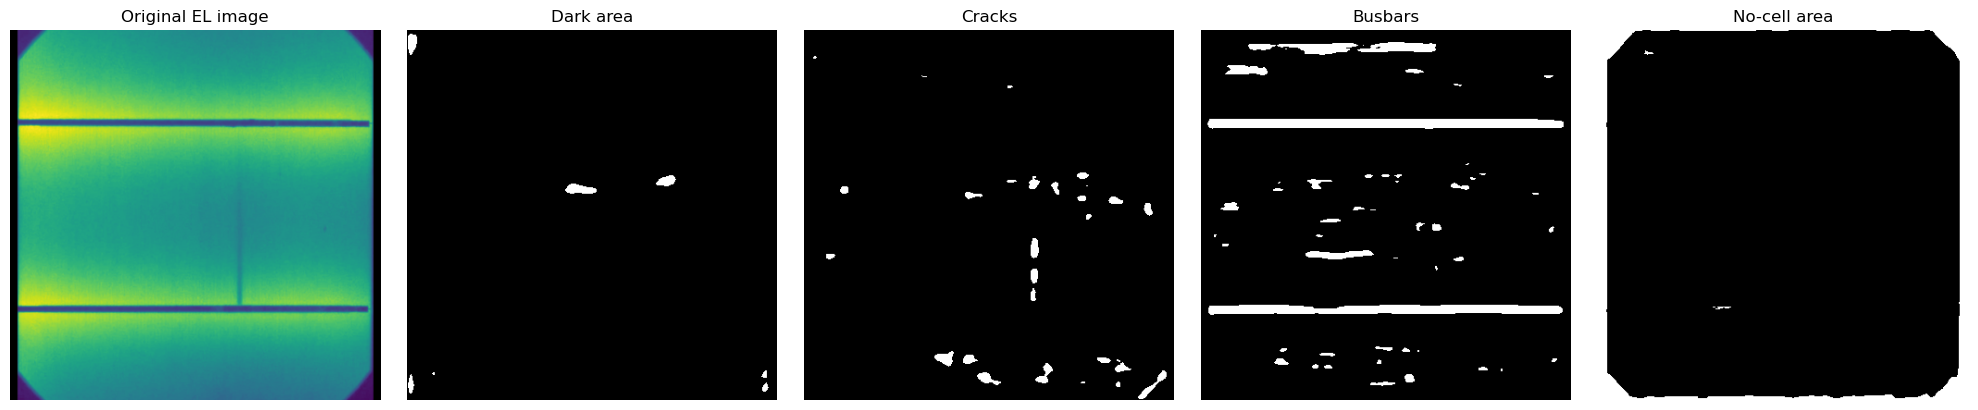

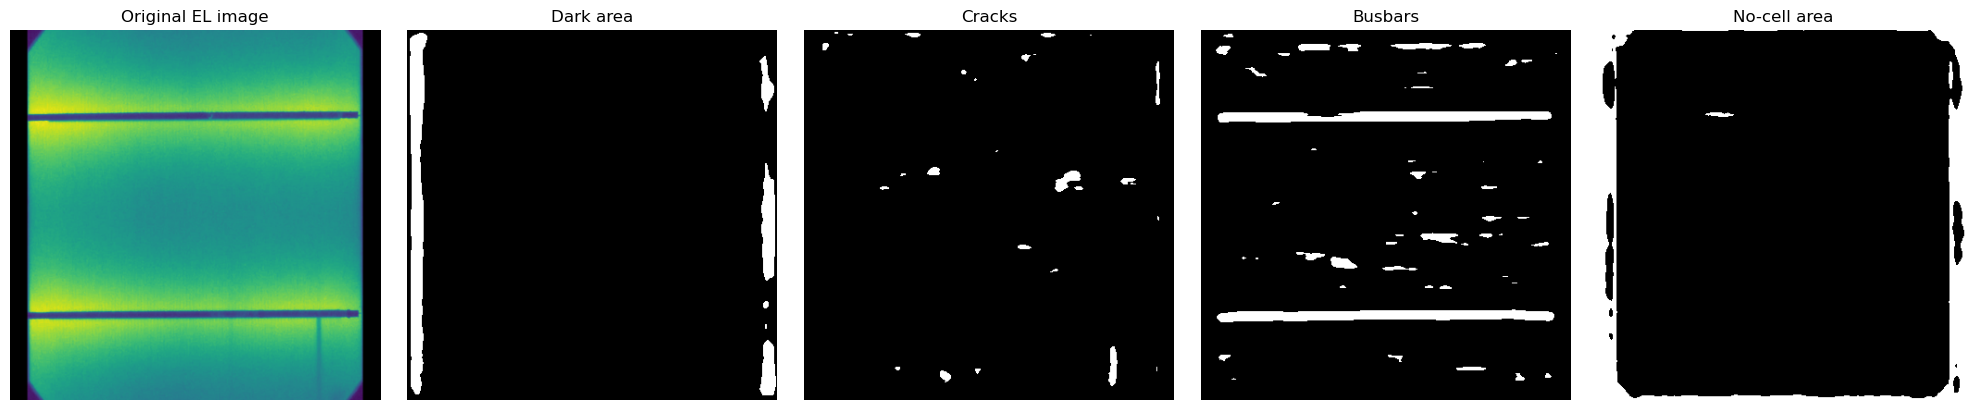

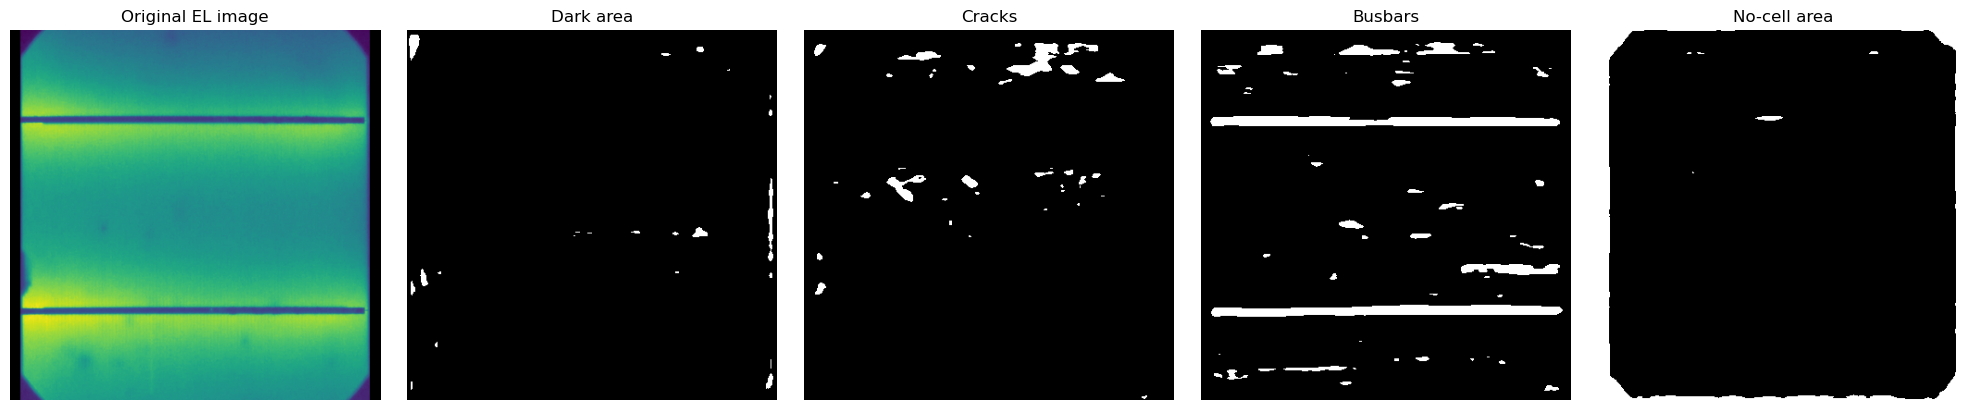

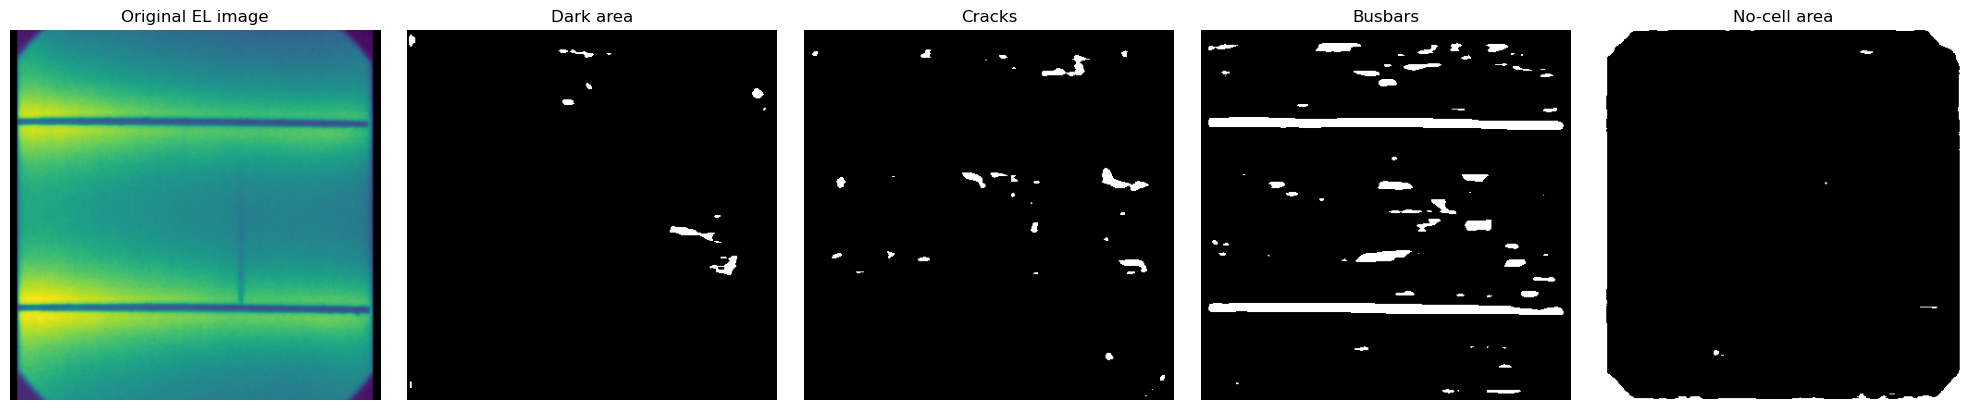

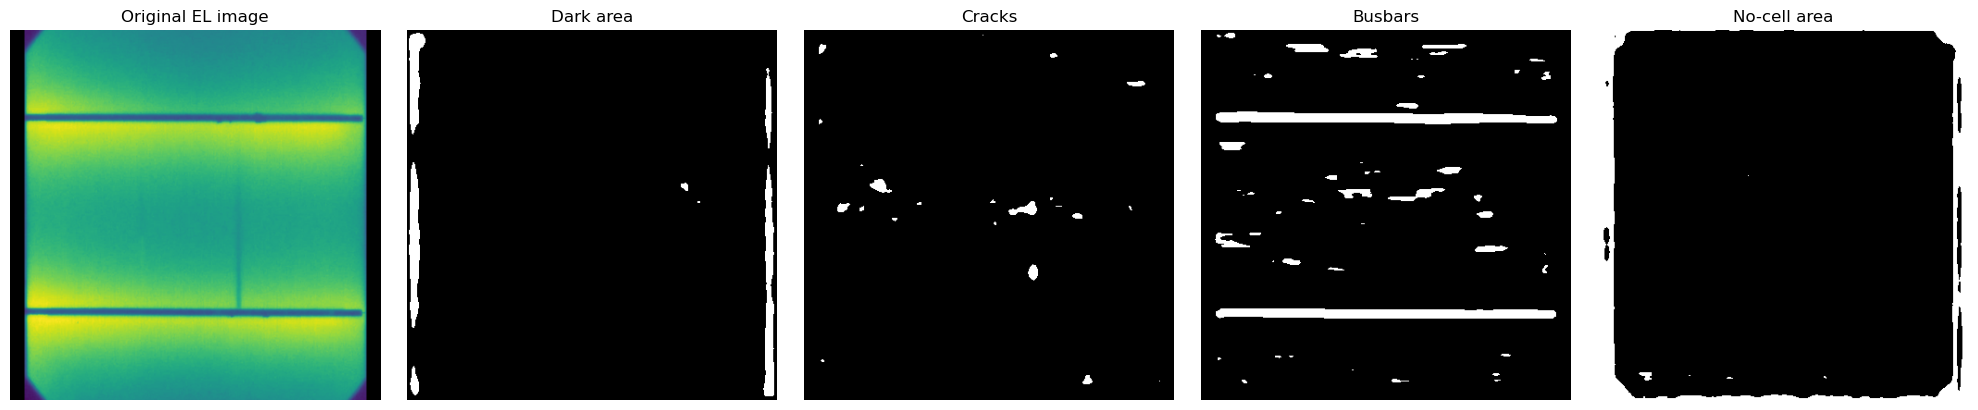

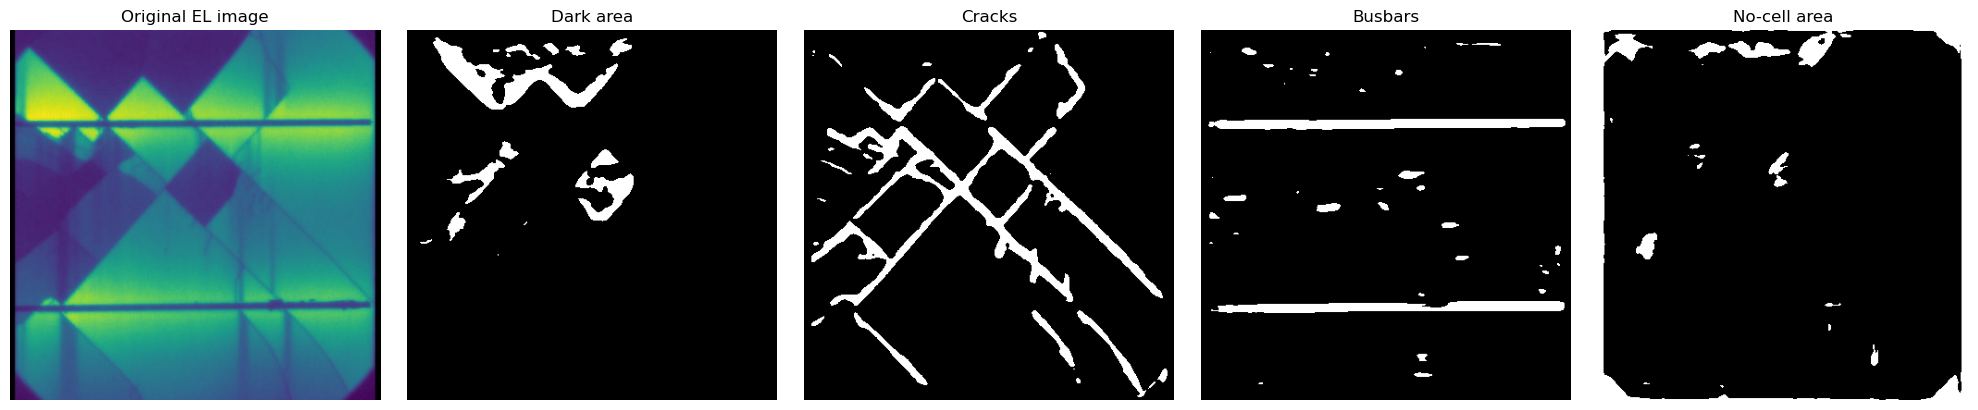

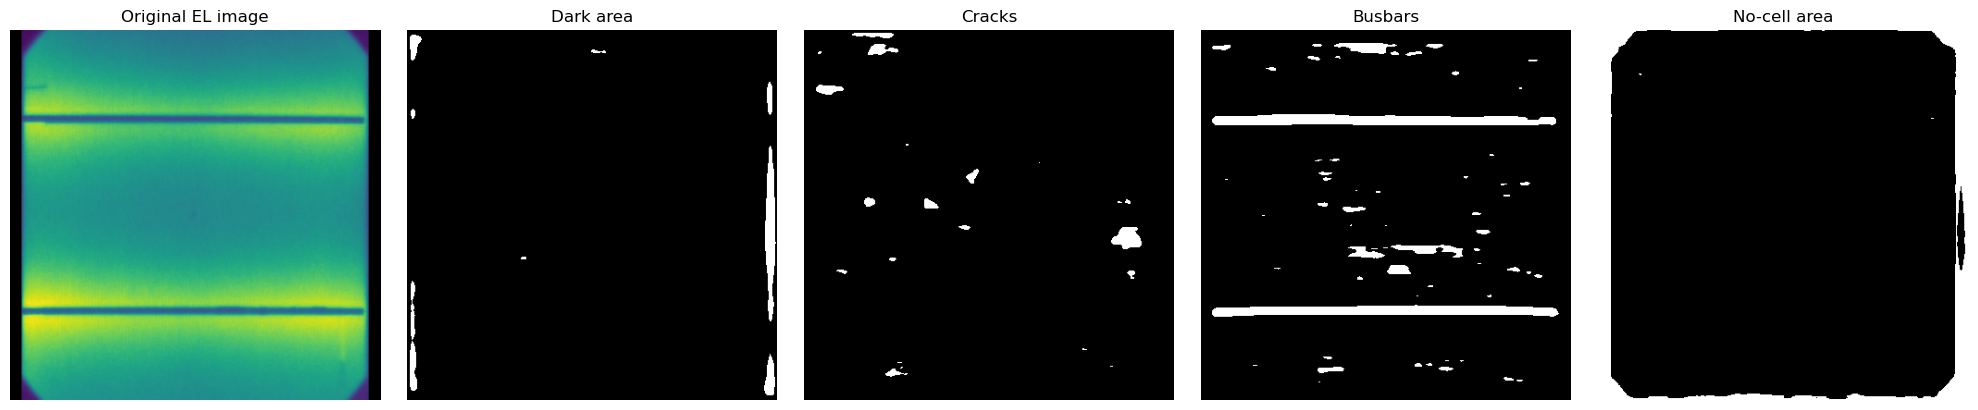

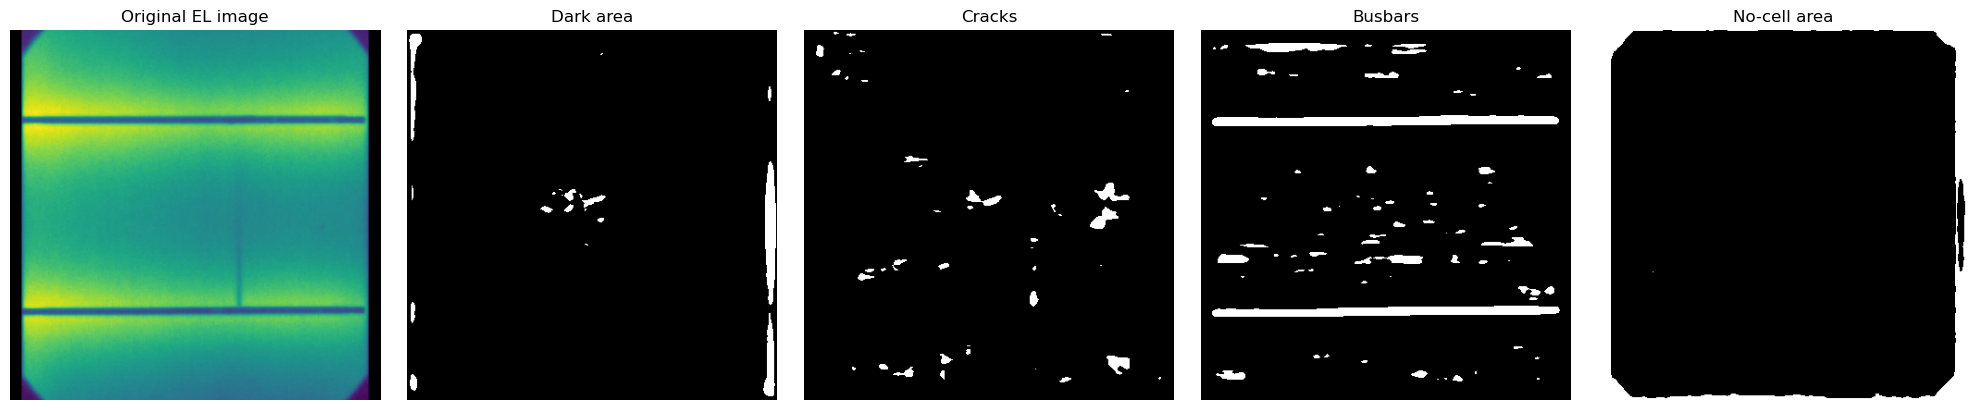

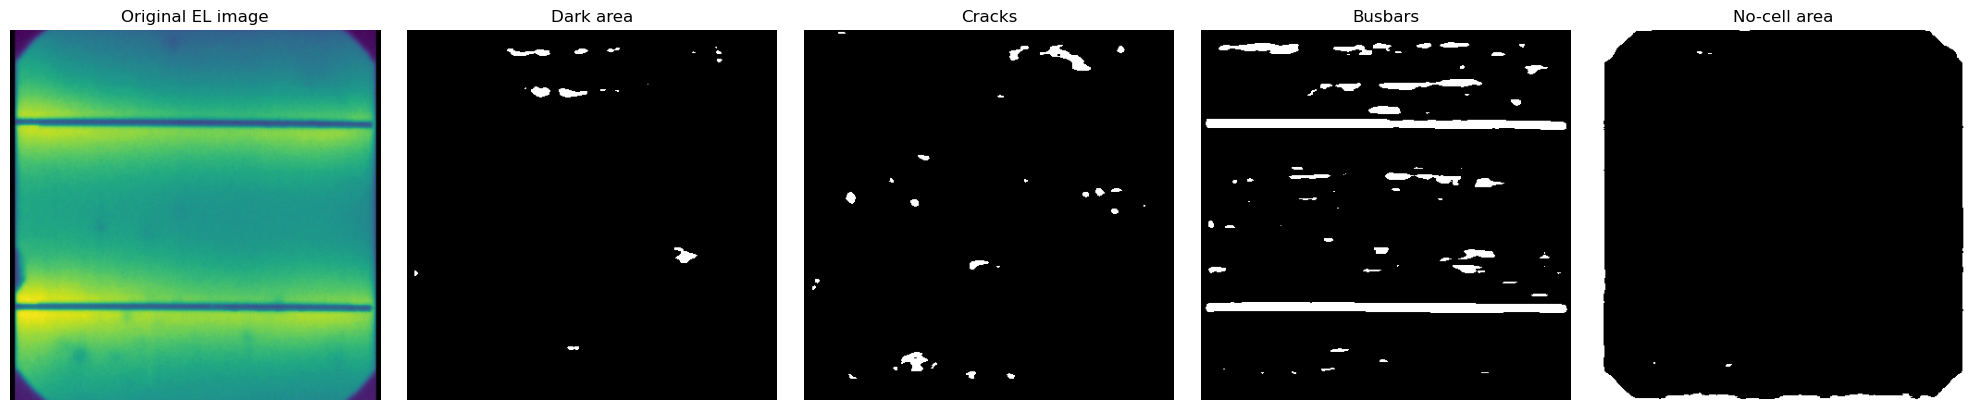

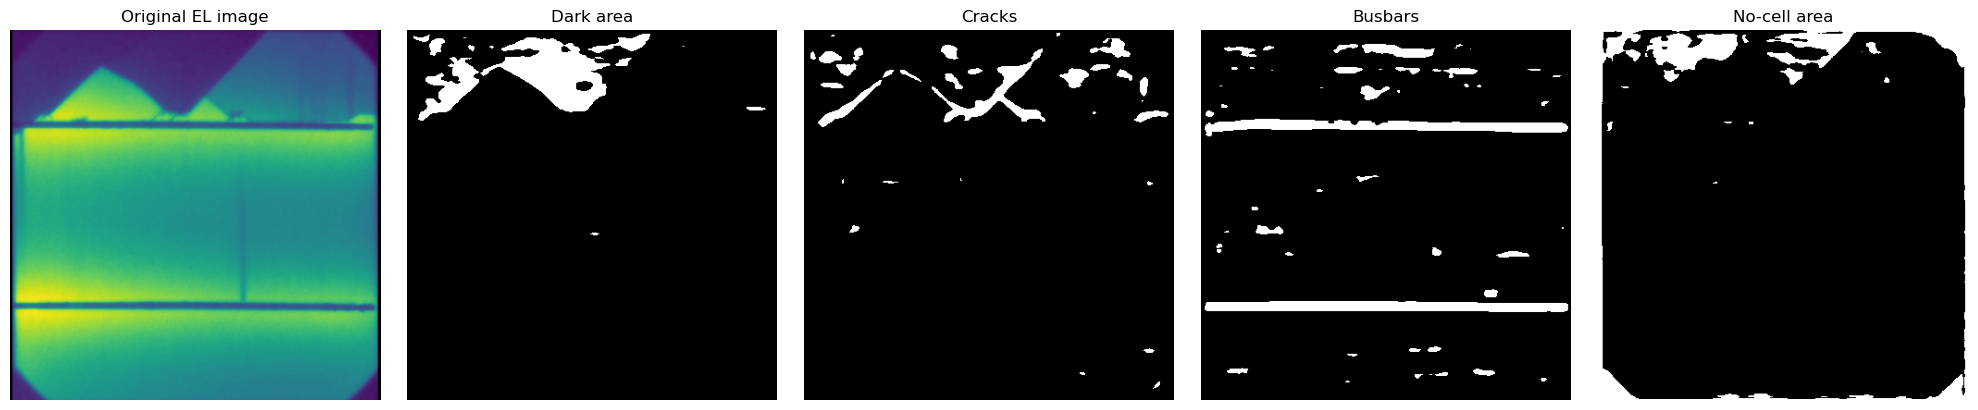

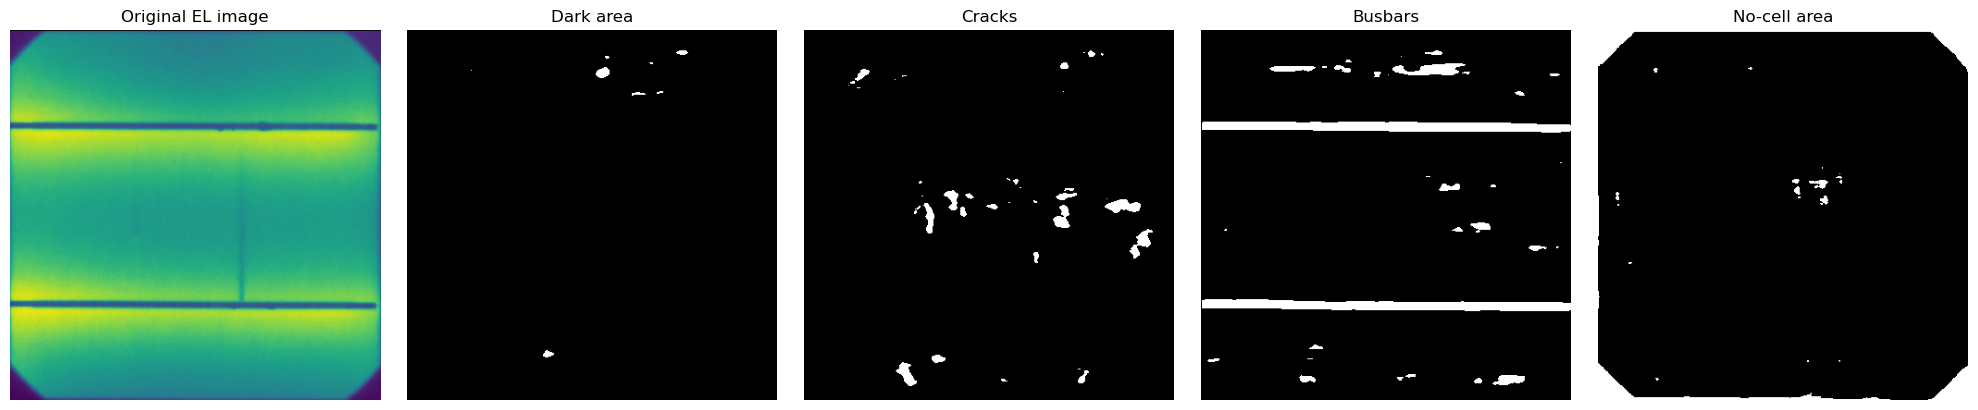

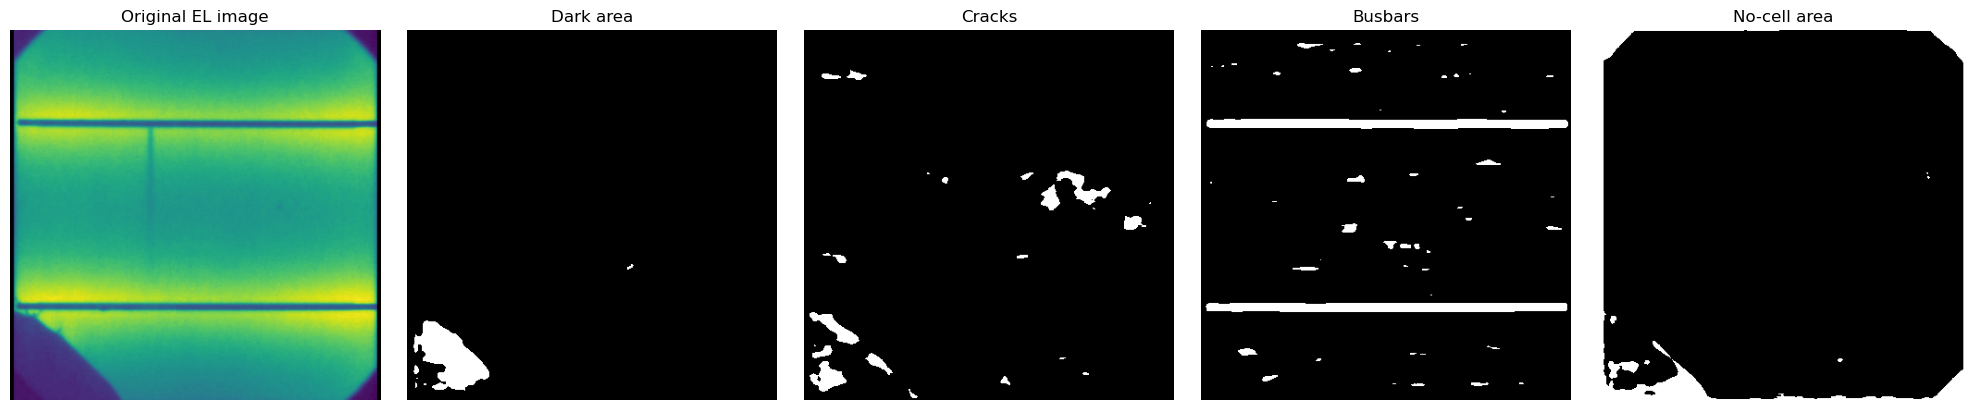

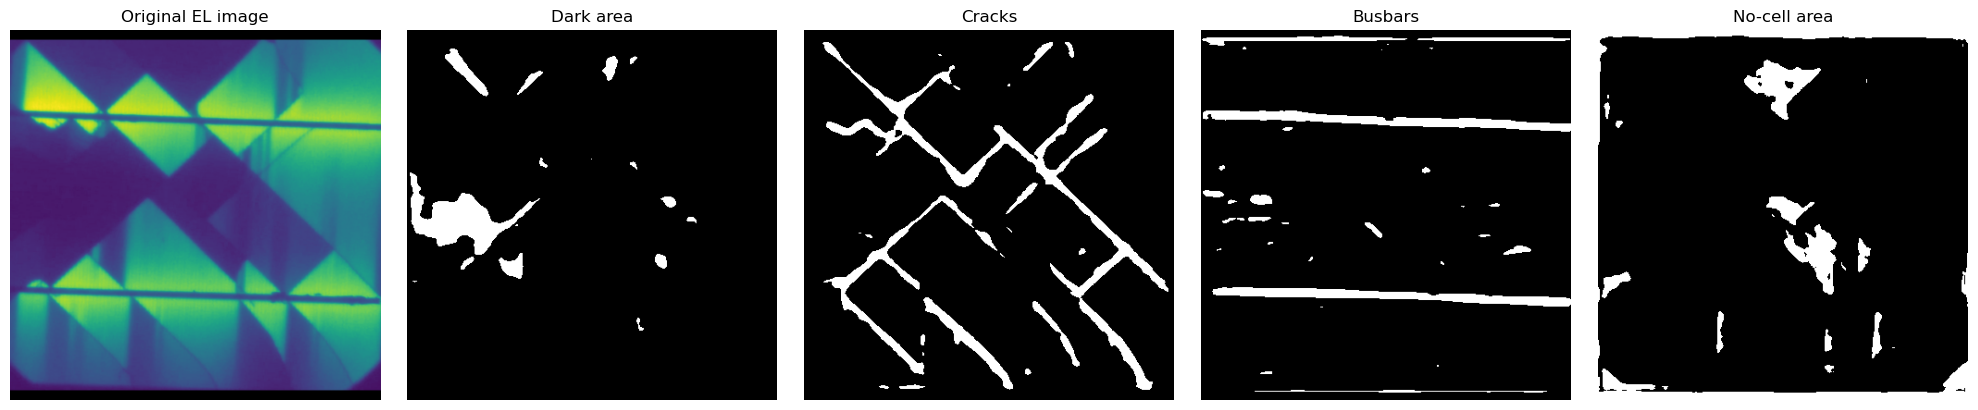

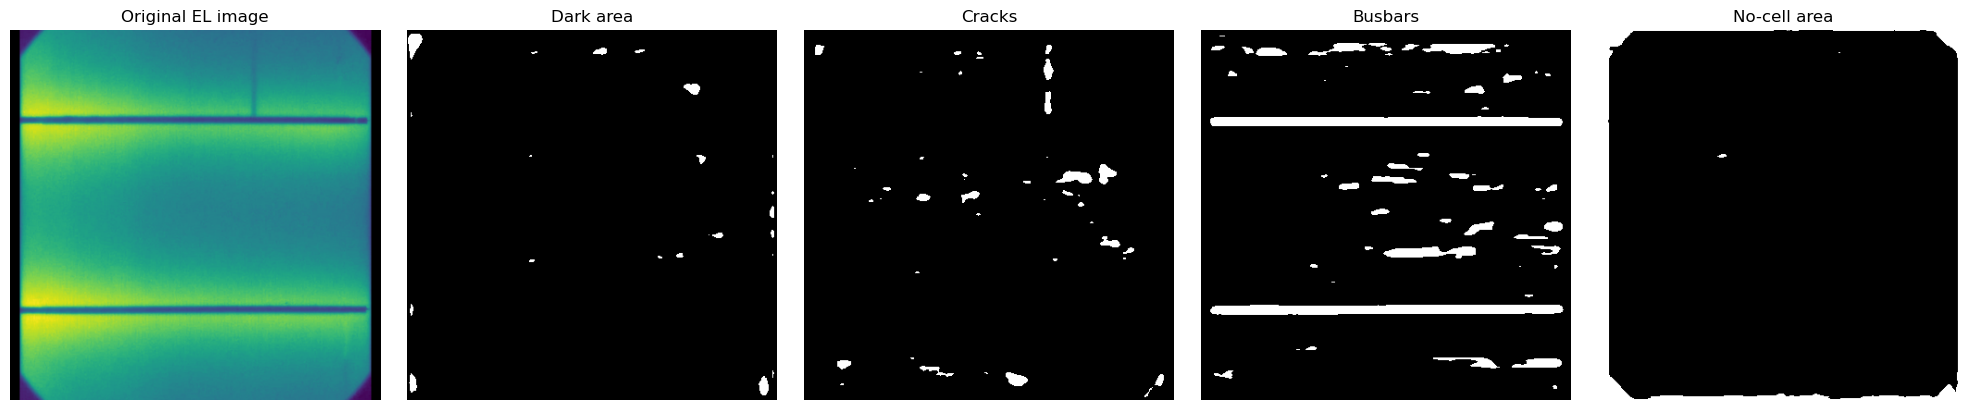

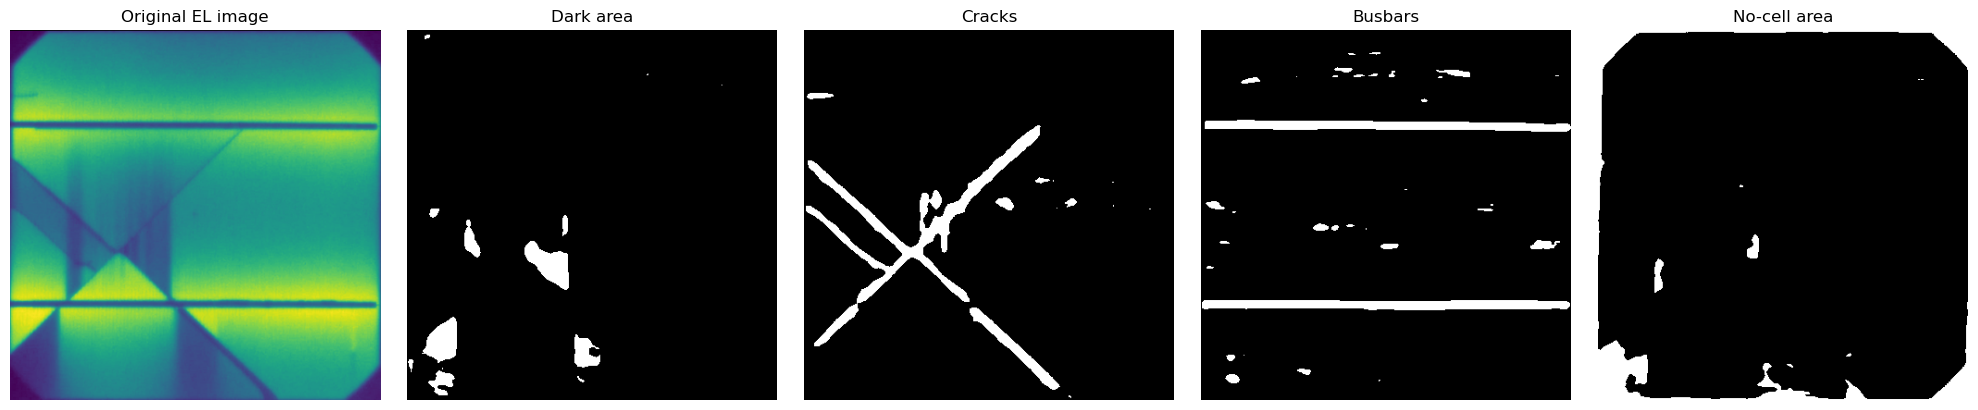

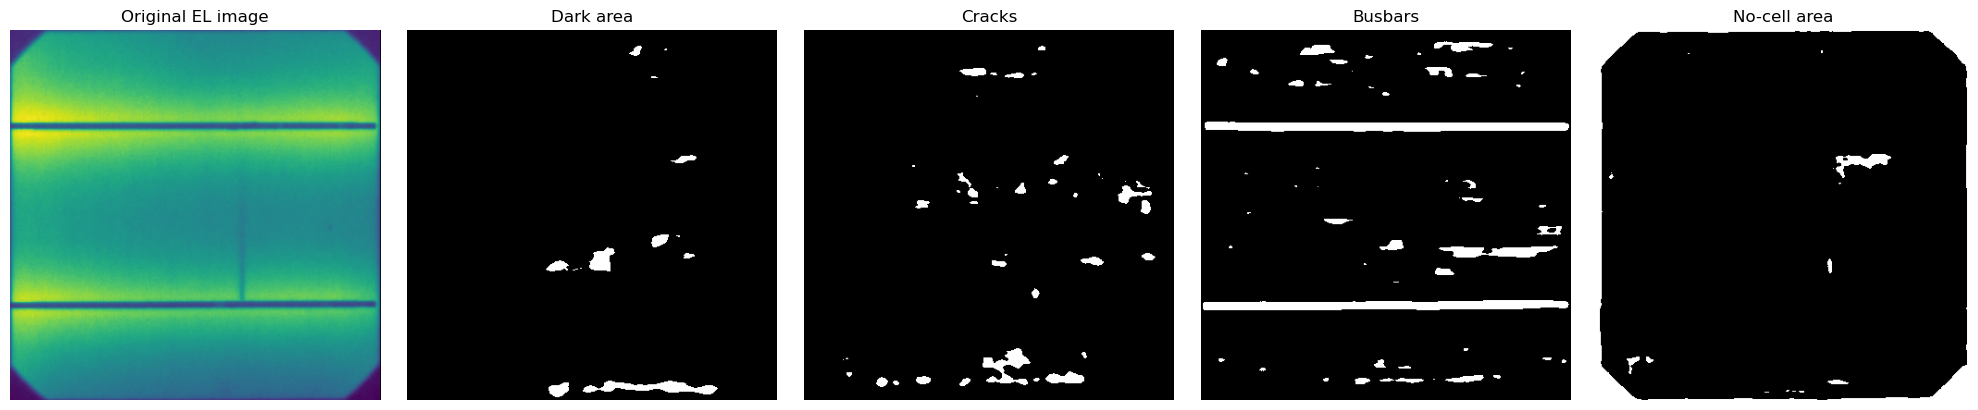

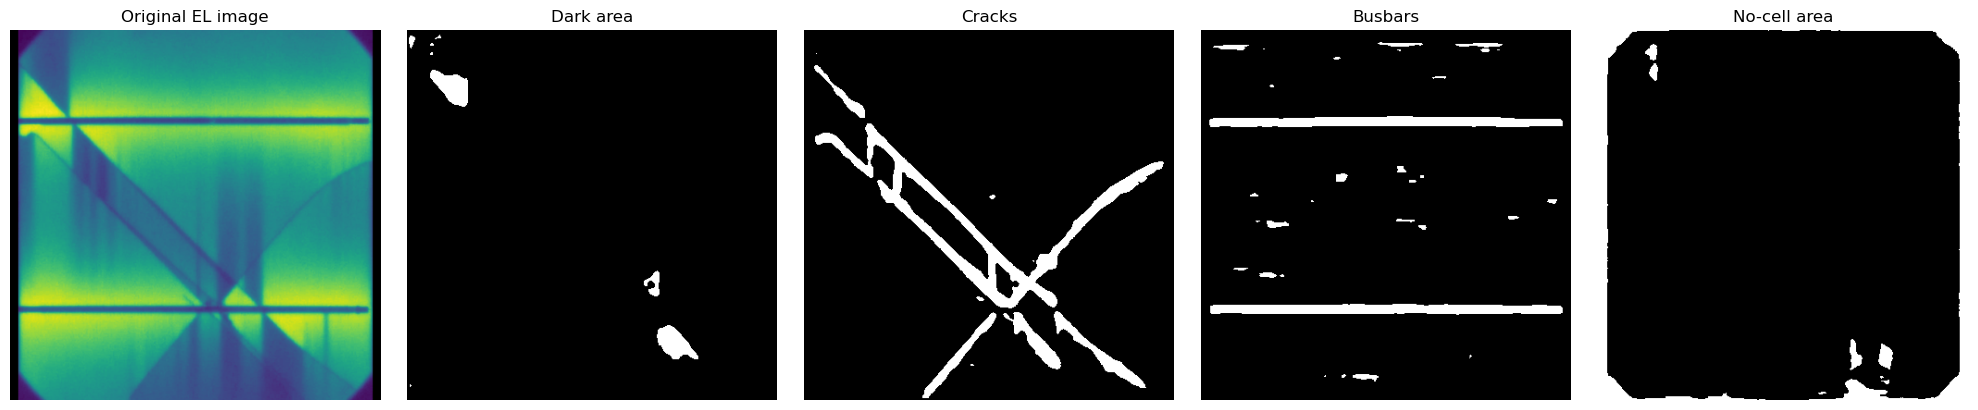

In [9]:
for ind, row in Cell9Master.iterrows():
    image_raw = Image.open(f"{os.getcwd()}{row.ELPath}") #Load image with PIL
    image_rgb = image_raw.convert("RGB") #Convert to GPB
    image_rot = image_rgb.rotate(90) #Rotate to have busbars horizontal to be detected with segmentation model
    image = F.resize(image_rot, (400, 400), interpolation=transforms.InterpolationMode.BILINEAR)
    
    dark, bb, crack, nocell = segment(image, device, model) #segment

    arrays = [image, dark, crack, bb, nocell]
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))    
    for ax, arrimg, title in zip(axes, arrays, titles):
        im = ax.imshow(arrimg, cmap="gray")   # or choose another cmap
        ax.set_title(title, fontsize=12)
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()